# Evolutionary algorithm playground
Edit the parameters below and run the notebook from top to bottom to experiment with the EA.


## Imports and setup


In [1]:
import random
from pathlib import Path
import sys

# Ensure backend/src is importable when running from the notebook dir or repo root
PROJECT_ROOT = None
for candidate in [Path.cwd().resolve(), *Path.cwd().resolve().parents]:
    module_root = candidate / "backend" / "src"
    if module_root.exists():
        PROJECT_ROOT = candidate
        if str(module_root) not in sys.path:
            sys.path.insert(0, str(module_root))
        break
if PROJECT_ROOT is None:
    raise RuntimeError("Could not locate backend/src. Run the notebook from the repo root.")

from ver0.evolver import (
    EAConfig,
    evolve,
    init_population,
    make_next_generation,
    make_random_layout,
    mutate,
    evaluate_population,
)
from ver0.fitness import Weights
from ver0.grid_encoder import encode_floorplan_to_grid, load_target_mask
from ver0.real_plan_classifier import classify_real_floorplan
from ver0.rl_bandit import make_seed_bandit
from ver0.seeders import SEEDING_REGISTRY
from ver0.vars import (
    DEFAULT_GRID_SIZE,
    POPULATION_SIZE,
    GENERATIONS,
    CROSSOVER_RATE,
    MUTATION_RATE,
    TOURNAMENT_K,
    ELITE_FRACTION,
    RANDOM_SEED,
    QUADRANT_WEIGHT,
    OVERLAP_WEIGHT,
    AREA_WEIGHT,
    COMPACTNESS_WEIGHT,
    ADJACENCY_WEIGHT,
    LOCATION_WEIGHT,
    SECTION_WEIGHT,
    DISPERSION_WEIGHT,
    ROOM_USAGE_WEIGHT,
    MASK_WEIGHT,
    BUDGET_WEIGHT,
    SECTION_BBOX_WEIGHT,
    RELATIONSHIP_WEIGHT,
    REALISM_WEIGHT,
    REALISM_THRESHOLD,
    NO_CHANGE_PENALTY,
    ROTATE_IMAGE_K,
)



## Parameters


In [2]:
FLOOR_ID = random.randint(1, 970)
GRID_SIZE = DEFAULT_GRID_SIZE
ROTATE_K = ROTATE_IMAGE_K  # multiples of 90deg (dataset is mostly consistent)

POPULATION_SIZE = 52
GENERATIONS = 30
CROSSOVER_RATE = 0.7
MUTATION_RATE = 0.25
TOURNAMENT_K = 3
ELITE_FRACTION = 0.08
RANDOM_SEED = random.randint(0, 1_000_000)

QUADRANT_WEIGHT = 0.9
OVERLAP_WEIGHT = 5.0
AREA_WEIGHT = 4.0
COMPACTNESS_WEIGHT = 3.5
ADJACENCY_WEIGHT = 0.6
LOCATION_WEIGHT = 1.2
SECTION_WEIGHT = 1.5
DISPERSION_WEIGHT = 1.0
ROOM_USAGE_WEIGHT = 1.5
MASK_WEIGHT = 2.0
BUDGET_WEIGHT = 3.0
SECTION_BBOX_WEIGHT = 2.5
RELATIONSHIP_WEIGHT = 1.0
REALISM_WEIGHT = 5.0
REALISM_THRESHOLD = 1.0
NO_CHANGE_PENALTY = 1.0

# Bandit seeder state (shared with RLTraining runs)
RL_STATE_PATH = PROJECT_ROOT / "backend" / "data" / "rl" / "seed_bandit.json"
BANDIT_EPSILON = 0.05  # low exploration at inference time

STAGNATION_THRESHOLD = 30
RESTART_FRACTION = 0.3
MUTATION_BOOST = 1.6
MUTATION_FLOOR = 0.05
MUTATION_CEILING = 0.75

EA_CONFIG = EAConfig(
    population_size=POPULATION_SIZE,
    generations=GENERATIONS,
    crossover_rate=CROSSOVER_RATE,
    mutation_rate=MUTATION_RATE,
    tournament_k=TOURNAMENT_K,
    elite_fraction=ELITE_FRACTION,
    random_seed=RANDOM_SEED,
    weights=Weights(
        quadrant=QUADRANT_WEIGHT,
        overlap=OVERLAP_WEIGHT,
        area=AREA_WEIGHT,
        compactness=COMPACTNESS_WEIGHT,
        adjacency=ADJACENCY_WEIGHT,
        location=LOCATION_WEIGHT,
        section=SECTION_WEIGHT,
        dispersion=DISPERSION_WEIGHT,
        room_usage=ROOM_USAGE_WEIGHT,
        budget=BUDGET_WEIGHT,
        section_bbox=SECTION_BBOX_WEIGHT,
        mask=MASK_WEIGHT,
        relationships=RELATIONSHIP_WEIGHT,
        realism=REALISM_WEIGHT,
    ),
    stagnation_threshold=STAGNATION_THRESHOLD,
    restart_fraction=RESTART_FRACTION,
    mutation_boost=MUTATION_BOOST,
    mutation_floor=MUTATION_FLOOR,
    mutation_ceiling=MUTATION_CEILING,
    no_change_penalty=NO_CHANGE_PENALTY,
)



## Load floor description sample


In [3]:
import json

floor_dir = PROJECT_ROOT / "backend" / "data" / "processed" / "floor_plans" / f"floor{FLOOR_ID:03d}"
meta_path = floor_dir / "metadata.json"

PROMPT_OVERRIDE = None  # set to a text description to bypass file metadata

support_text = None
meta = None
if PROMPT_OVERRIDE:
    support_text = PROMPT_OVERRIDE
elif meta_path.exists():
    meta = json.loads(meta_path.read_text())
    support_text = meta.get("supporting_text") or meta.get("support_text") or meta.get("text") or meta.get("scene_description")

if PROMPT_OVERRIDE:
    sample = encode_floorplan_to_grid(floor_dir, grid_size=GRID_SIZE, rotate_k=ROTATE_K, text_override=PROMPT_OVERRIDE)
else:
    sample = encode_floorplan_to_grid(floor_dir, grid_size=GRID_SIZE, rotate_k=ROTATE_K)

mask_array = sample.target_mask
has_mask = mask_array is not None

# Load bandit and pick seeding strategy
bandit = make_seed_bandit(RL_STATE_PATH, epsilon=BANDIT_EPSILON, rng=random.Random(RANDOM_SEED))
seed_name, seed_fn = bandit.select()
print(f"Using seeder: {seed_name}")

print("GridSample summary")
print("------------------")
print(f"floor_id:      {sample.floor_id}")
print(f"grid_size:     {sample.grid_size}")
print(f"num rooms:     {len(sample.rooms)}")
if sample.text_room_total:
    active_slots = len(sample.active_room_names or [])
    print(f"text rooms:    {sample.text_room_total} (active slots: {active_slots})")
print(f"has mask:      {has_mask}")
if support_text:
    print("Support text:", support_text)



Using seeder: section_tight_mask
GridSample summary
------------------
floor_id:      351
grid_size:     64
num rooms:     3
text rooms:    3 (active slots: 3)
has mask:      True
Support text: The first bedroom is located at north east. The dining and lounge are combined and are located at south.


## Run the evolutionary algorithm


In [4]:
import math
import matplotlib.pyplot as plt
import numpy as np

SNAPSHOT_COUNTER = max(1, (EA_CONFIG.generations // 10))

history = []
snapshots = []
counter = 0
rng = random.Random(EA_CONFIG.random_seed)
population = init_population(sample, EA_CONFIG, rng, seed_fn)

def layout_to_grid(sample, genome):
    grid_size = sample.grid_size
    grid = -1 * np.ones((grid_size, grid_size), dtype=int)
    for idx, spec in enumerate(sample.rooms):
        cells = genome.layout.placement.get(spec.name, [])
        for r, c in cells:
            if 0 <= r < grid_size and 0 <= c < grid_size:
                grid[r, c] = idx
    return grid

for gen in range(EA_CONFIG.generations):
    if gen > 0:
        population = make_next_generation(sample, population, EA_CONFIG, rng, seed_fn, mutate)

    evaluate_population(sample, population, EA_CONFIG)
    best_genome = min(population, key=lambda g: g.fitness if g.fitness is not None else float('inf'))
    history.append(best_genome.fitness)

    counter += 1
    if counter == SNAPSHOT_COUNTER:
        counter = 0
        snapshots.append({
            "gen": gen + 1,
            "fitness": best_genome.fitness,
            "grid": layout_to_grid(sample, best_genome),
        })

best = min(population, key=lambda g: g.fitness if g.fitness is not None else float('inf'))
print("Best fitness:", best.fitness)
if best.scores:
    print("Constraint breakdown:")
    for k, v in best.scores.__dict__.items():
        print(f" - {k}: {v}")

real_ok, real_score, real_detail = classify_real_floorplan(sample, best.layout)
print("Real plan?", real_ok, "score=", real_score)
print(real_detail)



Best fitness: 3117.860260894282
Constraint breakdown:
 - quadrant: 0.203125
 - overlap: 0.0
 - area: 0.0
 - compactness: 9.177067485490928
 - adjacency: 0.0
 - location: 0.6875
 - section: 0.28125
 - dispersion: 0.3840006510416667
 - room_usage: 0.0
 - budget: 0.0
 - section_bbox: 0.0
 - mask: 1537.0
 - relationships: 0.0
Real plan? False score= 2.985367308804399
{'overlap_norm': 0.0, 'budget': 0.0, 'area_norm': 0.0, 'section_miss': 0.0, 'dispersion_norm': np.float64(0.000727273960306187), 'compact_norm': 3.0590224951636427, 'mask_norm': 2.9109848484848486}


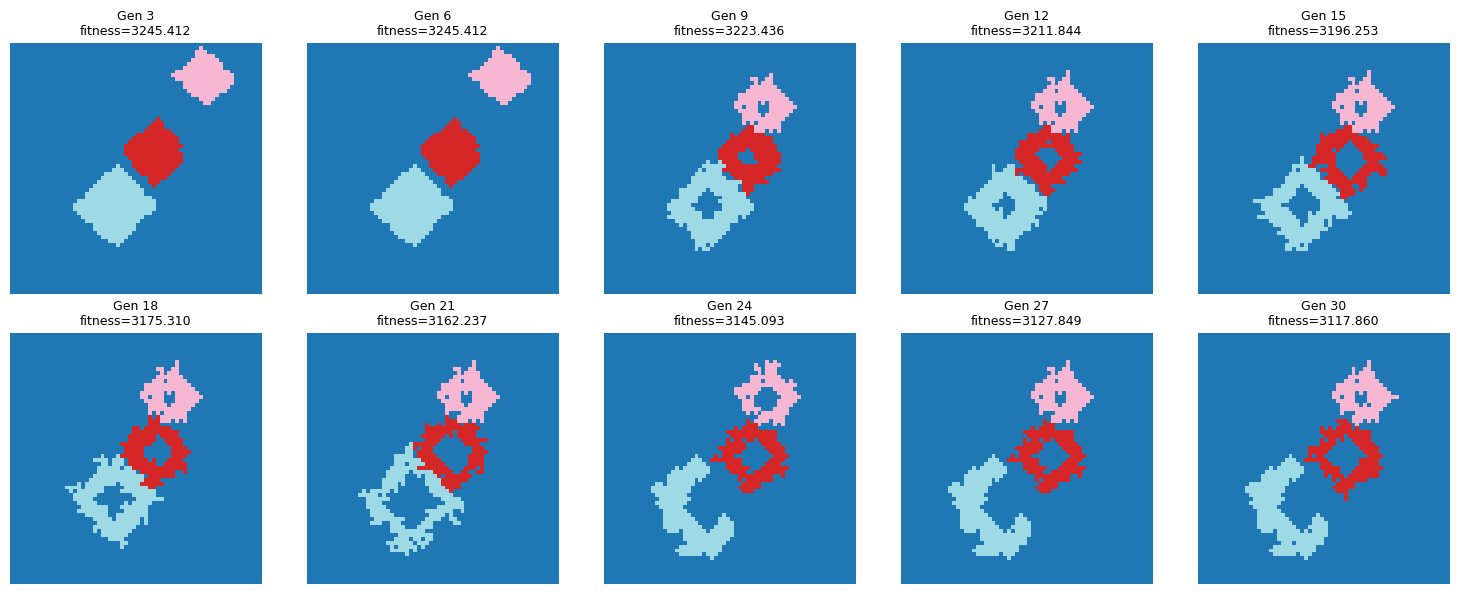

In [5]:
import math
import matplotlib.pyplot as plt
import numpy as np
if snapshots:
    ncols = min(5, len(snapshots))
    nrows = math.ceil(len(snapshots) / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 3))
    axes_arr = np.atleast_1d(axes).ravel()
    for ax in axes_arr:
        ax.axis('off')
    vmax = len(sample.rooms) - 1 if sample.rooms else 0
    for idx, snap in enumerate(snapshots):
        ax = axes_arr[idx]
        ax.imshow(snap['grid'], cmap='tab20', vmin=-1, vmax=vmax)
        ax.set_title(f"Gen {snap['gen']}\nfitness={snap['fitness']:.3f}", fontsize=9)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print('No snapshots captured (check SNAPSHOT_COUNTER).')


## Floorplan reference


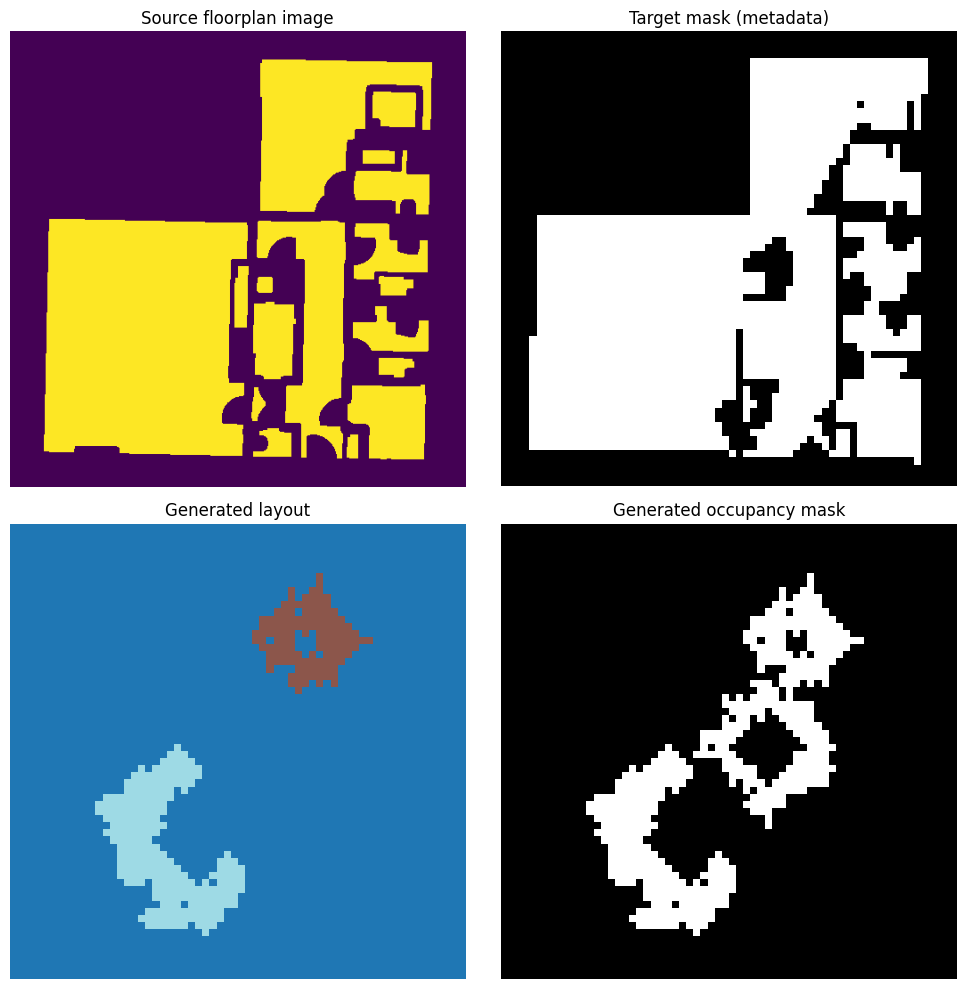

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob

rotate_k = 0  # force no rotation for display

candidates = []
for ext in ['png', 'jpg', 'jpeg', 'bmp']:
    candidates.append(floor_dir / f'floorplan.{ext}')
    candidates.append(floor_dir / f'map.{ext}')
    candidates.append(floor_dir / f'plan.{ext}')
for pattern in ['*.png','*.jpg','*.jpeg','*.bmp']:
    candidates += [Path(p) for p in glob.glob(str(floor_dir / pattern))]

img_path = next((p for p in candidates if p.exists()), None)
img_arr = None
if img_path:
    img_arr = mpimg.imread(img_path)

best_grid = layout_to_grid(sample, best)
best_mask = best_grid >= 0

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.ravel()

# Real floorplan image
if img_arr is not None:
    axes[0].imshow(img_arr)
    axes[0].set_title('Source floorplan image')
else:
    axes[0].set_title('No floorplan image found')
axes[0].axis('off')

# Target mask from metadata
if mask_array is not None:
    axes[1].imshow(mask_array, cmap='gray')
    axes[1].set_title('Target mask (metadata)')
else:
    axes[1].set_title('No target mask available')
axes[1].axis('off')

# Generated layout colored
vmax = len(sample.rooms) - 1 if sample.rooms else 0
axes[2].imshow(best_grid, cmap='tab20', vmin=0 if vmax>0 else -1, vmax=max(vmax,0))
axes[2].set_title('Generated layout')
axes[2].axis('off')

# Generated occupancy mask
axes[3].imshow(best_mask, cmap='gray')
axes[3].set_title('Generated occupancy mask')
axes[3].axis('off')

plt.tight_layout()
plt.show()


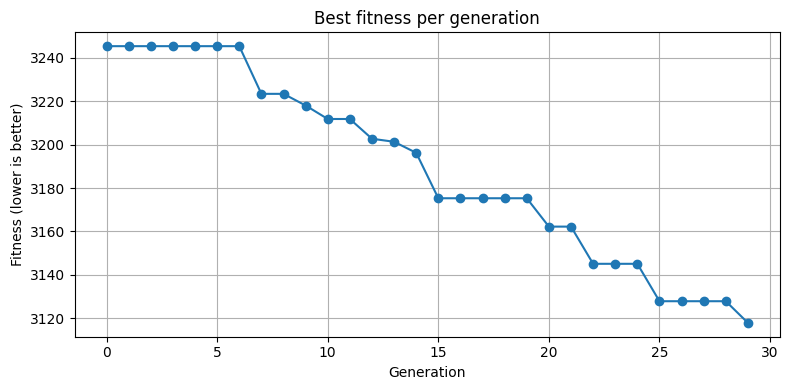

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(history, marker='o')
plt.title('Best fitness per generation')
plt.xlabel('Generation')
plt.ylabel('Fitness (lower is better)')
plt.grid(True)
plt.tight_layout()
plt.show()
